# Exercises

Learning a language requires _using_ it. This is why I can no longer speak French. 

This page gives two exercises for you to implement in Python. We will work through them in the workshop and discuss the best way to do them


## Exercise 1: Ratemaps

In the first exercise, you will calculate a Ratemap for cells in the Datajoint pipeline. 

Goal: given a `key` to the Datajoint table `analysis.TaskSpikesTracking`, create and display a Rate Map for that cell in that task. 

If you have not yet reconfigured your Datajoint client to access the latest version of the pipeline, you can find details [on the kavli wiki here](https://www.ntnu.no/wiki/display/kavli/DataJoint%3A+Electrophysiology+Pipeline). You will require your NTNU username, database password, and the access and secret keys to the object storage. 

### Algorithm

A ratemap takes in a list of animal positions, and a list of spike positions, and computes the rate of firing of that unit at each location in an arena. The provided code will extract tracking information about the animal's position (`pos_t` (seconds), `pos_x`, `pos_y` (cm)); and spike information ((`spk_t` (seconds), `spk_x`, `spk_y` (cm))

Based on these data, create:
* An occupancy map: a binned map of the time the animal spent in each location
* A spike map: a binned map of the number of unit spikes in each location
* A rate map: the rate at which the unit fires in each location

Plot the rate map using `matplotlib`

**Hint**: You will find the [NumPy Documentation](https://docs.scipy.org/doc/numpy) very useful, and the [2D histogram](https://docs.scipy.org/doc/numpy/reference/generated/numpy.histogram2d.html) function in particular

In [2]:
import os
import datetime
import numpy as np
import datajoint as dj
import matplotlib.pyplot as plt

SECRET_KEY = "56523d80ae3c413b91046476a31dc1e6"
ACCESS_KEY = "942676b240ab4b72951fe09e4c4a65de"
USER = 'simoba'
PASS = 'n78IJOQ7'

dj.config['database.host'] = 'datajoint.it.ntnu.no'
dj.config['database.user'] = USER
dj.config['database.password'] = PASS
dj.config["enable_python_native_blobs"] = True
dj.config["stores"] = {   'ephys_store': {   'access_key': ACCESS_KEY,
                                     'bucket': 'ephys-store-computed',
                                     'endpoint': 's3.stack.it.ntnu.no:443',
                                     'secure': True,
                                     'location': '',
                                     'protocol': 's3',
                                     'secret_key': SECRET_KEY},
                  'ephys_store_manual': {   'access_key': ACCESS_KEY,
                                            'bucket': 'ephys-store-manual',
                                            'endpoint': 's3.stack.it.ntnu.no:443',
                                            'secure': True,
                                            'location': '',
                                            'protocol': 's3',
                                            'secret_key': SECRET_KEY}}
dj.config['custom'] = {
        'database.prefix': 'group_shared_',
        'mlims.database': 'prod_mlims_data',
        'flask.database': 'group_shared_flask',
        'drive_config': {
          'local': 'C:/',
          'network': 'N:/'}}
analysis = dj.create_virtual_module('analysis', 'group_shared_analysis')
analysis_param = dj.create_virtual_module('analysis_param', 'group_shared_analysis_param')

key = {'animal_id': '40bfa03a7a7018cc',
 'datasource_id': 0,
 'session_time': datetime.datetime(2019, 9, 27, 15, 50, 36),
 'unit': 353,
 'task_type': 'OpenField',
 'task_start': '6742.00',
 'task_spike_tracking_hash': '94d2fad2fbb66aaef6b18cdc51653923',
 'occu_params_name': 'megaspace-std-occ',
 'smoothing_params_name': 'default',
 'analysis_package': 'python',
 'cell_selection_params_name': 'default',
 'field_detect_params_name': 'default',
 'score_params_name': 'default'}

Connecting simoba@datajoint.it.ntnu.no:3306


In [20]:
pos_t, pos_x, pos_y = (analysis.TaskTracking & key).fetch1("task_timestamps", "x_pos", "y_pos")
spk_t, spk_x, spk_y = (analysis.TaskSpikesTracking & key).fetch1("spike_times", "x_pos", "y_pos")

In [21]:
(analysis.TaskTracking & key)

animal_id,datasource_id,session_time start time of this session,task_type,task_start (s) timestamp of task onset with respect to the start of the session,task_timestamps (s) task-related spike times (time with respect to the start of the task),speed (cm/s) task-related speed,x_pos (cm) task-related x-pos,y_pos (cm) task-related y-pos,z_pos (cm) task-related z-pos,head_yaw (degree) task-related head yaw (left/right angle),head_pitch (degree) task-related head pitch (up/down),head_roll (degree) task-related head roll (clockwise/anticlockwise),angular_speed (degree/s) task-related head angular speed
40bfa03a7a7018cc,0,2019-09-27 15:50:36,OpenField,6742.00,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=


C:\Users\simoba\AppData\Local\Continuum\anaconda3\envs\dj\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


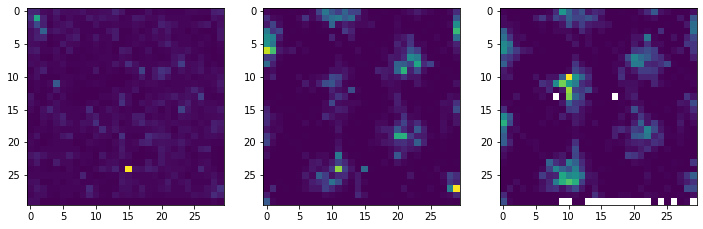

In [36]:
num_bins = 30

time_map, xedge, yedge = np.histogram2d(pos_x, pos_y, bins=num_bins)
spike_map, xedge, yedge = np.histogram2d(spk_x, spk_y, bins=num_bins)


fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(12, 16))
ax1.imshow(time_map)
ax2.imshow(spike_map)
ax3.imshow(spike_map/time_map)


## Exercise 2: Working with less-structured data

Fortunately, the Datajoint framework gives us a repository for storing strongly structured data, making it much easier to query. Not everything is so nice, however. In the /data folder are 2 data file from my PhD work, `photons_1.txt`, `photons_2.txt`. The first is small and useful for testing. The second will take rather more time to work with, but is much mroe interesting. 

`photons_2.txt` contains approximately 2.2 million lines of data. Each line is structured as follows:
* 12 hexadecimal digits of a 200MHz clock counter (i.e. each tick is 5ns)
* 4 hexadecimal digits, each corresponding to one channel of the photon detection system. 
  - 0 - detector off
  - 4 - detector on
  - 5 - detector on, new shot trigger on (channel 4 only)
  - 6 - photon detected
  - 7 - photon detected, new shot trigger on (channel 4 only)

Given metadata that:
1. Each 25000 shots constitute one cycle
2. Each 41 cycles constitute one experimental repeat
3. Each repeat can be summed with each other repeat
Plot the number of photons detected as a function of each shot

#### Algorithm
* Load the data file
* Iterate over the data to go from string to three arrays (`time`, `values`, `new_shot`)
* 


**Hints**:
* You can convert from a hex string to a number with `int(hex_string, 16)`
* Remember that you can index a string just like a list

In [10]:
with open("data/photons_2.txt","r") as f:
    data = f.readlines()
times = np.zeros(len(data))
values = np.zeros((len(data), 4))
new_shot = np.zeros(len(data)).astype(bool)
for i, row in enumerate(data):
    times[i] = int(row[:12], 16) * 5e-9 # Separate times and convert to number of cycles, then to seconds
    values[i] = np.floor( np.array(list(row[12:16])).astype(int)/6 ) # separate channels and convert to whether photon observed
    new_shot[i] = int(row[15])%2 != 0 # If the final channel is odd, then the new_cycle is true


In [19]:
# Plot as frequency scan
## Sum all photons counted within a single iterated value

shots_per_cycle = 25000
iterations = 41
photons = np.zeros(iterations)
shot = 0
for i in range(len(times)):
    shot += int(new_shot[i])
    iteration = int(shot/shots_per_cycle)%iterations
    photons[iteration] += np.sum(values[i])


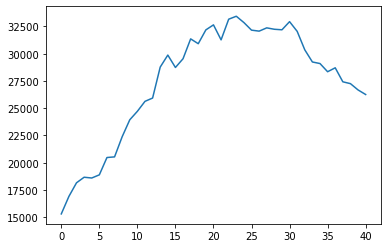

In [20]:
plt.plot(photons)

In [15]:
# Plot as storage
## Sum all photons occurred within the same clock cycle after the beginning of the shot

cycles_per_shot = int(np.mean(np.diff(times[new_shot])/5e-9))
photons = np.zeros(cycles_per_shot)
zero = times[0]
for i in range(len(times)):
    if new_shot[i]:
        zero = times[i]
    j = int((times[i] - zero)/5e-9)
    photons[j] += np.sum(values[i])
    

IndexError: index 25628493 is out of bounds for axis 0 with size 22

In [13]:
np.diff(times[new_shot])/5e-9

array([910., 910., 910., ..., 910., 910., 910.])

In [16]:
new_shot

array([False, False, False, ..., False,  True, False])